In [1]:
import numpy as np
import pandas as pd

def Ackley(x1, x2):
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return z

def GetGrid(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = Peaks(x, y)
    return x, y, z

def create_dataframe(grid):
   x, y, z = GetGrid(grid)
   data = {'x1': x.flatten(), 'x2': y.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Gaussian")

/tmp/ipykernel_92664/3623673326.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


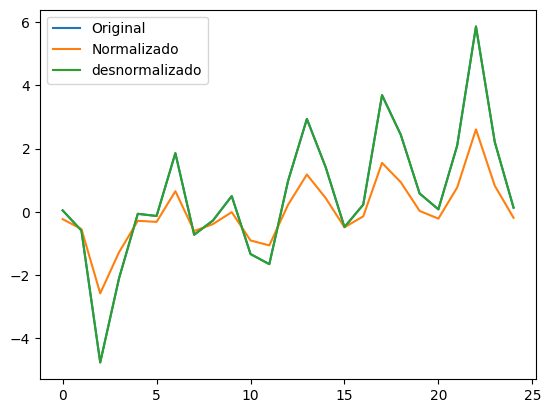

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...


remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 1.50 MiB/s, done.


Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-09-09 19:04:37.161821: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-09 19:04:37.209040: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 19:04:37.209081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 19:04:37.210433: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 19:04:37.218814: I tensorflow/core/platform/cpu_feature_guar

2024-09-09 19:04:38.436126: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[12, 2]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[12, 2], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  9


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 11ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 116ms/step


 1/32 [..............................] - ETA: 0s

 6/32 [====>.........................] - ETA: 0s

11/32 [=========>....................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 12ms/step


+++++++++++ [1_0] | 2 ++++++++++++++++++


Stopped at epoch:  17
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 116ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 8ms/step


+++++++++++ [1_0] | 3 ++++++++++++++++++


Stopped at epoch:  7


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


 1/32 [..............................] - ETA: 0s

 9/32 [=======>......................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_0] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 9ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 162ms/step


 1/32 [..............................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_0] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_0] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 37ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_0] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 75ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_0] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_1] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_1] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_1] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 8ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_1] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 10 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_1,0.883463,0.702596,0.741144,0.853835,0.485089,1.988742,0.925914,0.715807,0.737690,0.696483,8.458373,0.707452,131.446847,272.782019
model_1_2_0,0.881362,0.700731,0.740222,0.852240,0.493836,2.001213,0.929210,0.723622,0.744747,0.702734,8.592862,0.713802,131.411105,272.746277


DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 5 ++++++++++++++++++

Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 7 ++++++++++++++++++

Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_9,0.930996,0.739986,0.769200,0.913846,0.287231,1.738716,0.825558,0.232279,0.540548,0.535939,5.416251,0.544380,132.494939,273.830112
model_1_3_8,0.925860,0.735722,0.765807,0.908598,0.308609,1.767230,0.837696,0.246428,0.541818,0.555526,5.744946,0.564275,132.351361,273.686534
model_1_3_7,0.924682,0.734786,0.764976,0.908051,0.313513,1.773484,0.840666,0.247903,0.538213,0.559923,5.820356,0.568741,132.319826,273.654999
model_1_3_6,0.923185,0.733694,0.763875,0.906217,0.319744,1.780789,0.844604,0.252846,0.544136,0.565459,5.916153,0.574365,132.280469,273.615642
model_1_3_5,0.921772,0.732706,0.762664,0.905115,0.325628,1.787394,0.848937,0.255819,0.545833,0.570638,6.006617,0.579625,132.244001,273.579173
model_1_3_4,0.920196,0.731427,0.761629,0.903076,0.332186,1.795949,0.852640,0.261317,0.548457,0.576355,6.107445,0.585432,132.204123,273.539296
model_1_3_3,0.908184,0.721755,0.752498,0.887204,0.382186,1.860627,0.885299,0.304107,0.639623,0.618212,6.876214,0.627948,131.923696,273.258869
model_1_3_2,0.906825,0.720928,0.751299,0.886265,0.387843,1.866158,0.889588,0.306640,0.640292,0.622770,6.963190,0.632578,131.894311,273.229483
model_1_3_1,0.904787,0.718809,0.749732,0.883550,0.396328,1.880325,0.895194,0.313960,0.635277,0.629546,7.093647,0.639460,131.851028,273.186201
model_1_3_0,0.902906,0.717329,0.748450,0.881182,0.404155,1.890220,0.899781,0.320344,0.638576,0.635732,7.213989,0.645744,131.811916,273.147088


DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 10 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_9,0.963408,0.771660,0.787160,0.948401,0.152315,1.526911,0.761317,0.161984,0.437676,0.390276,3.341889,0.396422,133.763606,275.098778
model_1_4_8,0.955785,0.764532,0.780497,0.936863,0.184046,1.574575,0.785149,0.198205,0.470628,0.429006,3.829766,0.435763,133.385134,274.720306
model_1_4_7,0.954945,0.763670,0.779909,0.935544,0.187544,1.580343,0.787254,0.202344,0.472611,0.433063,3.883535,0.439883,133.347488,274.682660
model_1_4_6,0.946554,0.754848,0.777397,0.923595,0.222469,1.639333,0.796239,0.239857,0.476309,0.471667,4.420528,0.479095,133.005932,274.341104
model_1_4_5,0.945637,0.754218,0.776244,0.922222,0.226289,1.643545,0.800362,0.244167,0.490186,0.475698,4.479255,0.483190,132.971885,274.307058
model_1_4_4,0.944227,0.752825,0.775695,0.920268,0.232155,1.652862,0.802326,0.250300,0.495178,0.481825,4.569446,0.489413,132.920701,274.255873
model_1_4_3,0.939078,0.747090,0.774224,0.913794,0.253589,1.691209,0.807586,0.270623,0.506863,0.503576,4.898994,0.511507,132.744085,274.079257
model_1_4_2,0.935001,0.743454,0.771733,0.907997,0.270560,1.715524,0.816498,0.288823,0.524645,0.520153,5.159928,0.528345,132.614526,273.949699
model_1_4_1,0.933723,0.742328,0.771046,0.906267,0.275879,1.723052,0.818954,0.294252,0.527922,0.525242,5.241715,0.533514,132.575586,273.910759
model_1_4_0,0.932354,0.741163,0.770143,0.904213,0.281577,1.730842,0.822186,0.300703,0.534961,0.530638,5.329325,0.538995,132.534698,273.869871


DataFrame salvo em ../results/metrics_1_4


+++++++++++ [1_5] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.982045,0.801496,0.780318,0.976093,0.074738,1.327398,0.785791,0.097923,0.480137,0.273383,2.149118,0.277688,135.187532,276.522705
model_1_5_8,0.981757,0.801175,0.779679,0.975868,0.075935,1.329542,0.788077,0.098843,0.484862,0.275563,2.167522,0.279903,135.155755,276.490928
model_1_5_7,0.981500,0.800480,0.779591,0.975042,0.077006,1.334191,0.788390,0.102226,0.487311,0.277500,2.183992,0.281870,135.127738,276.462911
model_1_5_6,0.980193,0.797978,0.777144,0.974874,0.082446,1.350919,0.797144,0.102914,0.503600,0.287134,2.267631,0.291656,134.991223,276.326395
model_1_5_5,0.980194,0.797451,0.778393,0.975701,0.082444,1.354446,0.792676,0.099528,0.498345,0.287131,2.267603,0.291653,134.991266,276.326439
model_1_5_4,0.977830,0.794988,0.773614,0.973934,0.092285,1.370919,0.809771,0.106766,0.536201,0.303785,2.418911,0.308569,134.765743,276.100915
model_1_5_3,0.974782,0.790610,0.771444,0.970478,0.104972,1.400193,0.817533,0.120923,0.539563,0.323994,2.613977,0.329097,134.508119,275.843291
model_1_5_2,0.973797,0.781378,0.786216,0.973305,0.109069,1.461929,0.764691,0.109343,0.386513,0.330256,2.676965,0.335457,134.431551,275.766723
model_1_5_1,0.968614,0.778659,0.787638,0.964309,0.130643,1.480111,0.759607,0.146189,0.447204,0.361446,3.008677,0.367139,134.070569,275.405741
model_1_5_0,0.963985,0.772116,0.787825,0.957760,0.149915,1.523862,0.758939,0.173013,0.436317,0.387188,3.304982,0.393286,133.795376,275.130549


DataFrame salvo em ../results/metrics_1_5


+++++++++++ [1_6] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 4 ++++++++++++++++++


Stopped at epoch:  7


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 6 ++++++++++++++++++

Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_9,0.986661,0.808386,0.788251,0.988994,0.055523,1.281326,0.757414,0.046923,0.430069,0.235633,1.853680,0.239344,135.781919,277.117091
model_1_6_8,0.986394,0.807855,0.787324,0.988651,0.056637,1.284876,0.760730,0.048385,0.436101,0.237985,1.870804,0.241733,135.742198,277.077371
model_1_6_7,0.986104,0.807396,0.786664,0.988372,0.057843,1.287942,0.763091,0.049576,0.440867,0.240505,1.889350,0.244293,135.700050,277.035222
model_1_6_6,0.985801,0.806895,0.786158,0.988073,0.059103,1.291293,0.764901,0.050852,0.447292,0.243112,1.908729,0.246940,135.656938,276.992110
model_1_6_2,0.984375,0.806883,0.783336,0.986407,0.065039,1.291377,0.774993,0.057954,0.472843,0.255027,1.999988,0.259043,135.465546,276.800719
model_1_6_5,0.985509,0.806404,0.785469,0.987765,0.060317,1.294574,0.767365,0.052165,0.452062,0.245596,1.927394,0.249463,135.616276,276.951449
model_1_6_4,0.985277,0.805999,0.784997,0.987490,0.061286,1.297283,0.769054,0.053333,0.455766,0.247560,1.942289,0.251459,135.584408,276.919580
model_1_6_3,0.984940,0.805348,0.784437,0.987184,0.062689,1.301638,0.771057,0.054638,0.465648,0.250377,1.963853,0.254320,135.539154,276.874327
model_1_6_1,0.982662,0.802772,0.781816,0.984449,0.072172,1.318867,0.780431,0.066299,0.477133,0.268648,2.109658,0.272879,135.257418,276.592590
model_1_6_0,0.982259,0.802132,0.781124,0.983896,0.073846,1.323145,0.782906,0.068659,0.481491,0.271745,2.135397,0.276025,135.211558,276.546730


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 2 ++++++++++++++++++


Stopped at epoch:  7


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 4 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 5 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 131ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 85ms/step


 1/32 [..............................] - ETA: 1s

 8/32 [======>.......................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 7ms/step


+++++++++++ [1_7] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 102ms/step


 1/32 [..............................] - ETA: 3s

 6/32 [====>.........................] - ETA: 0s

11/32 [=========>....................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 12ms/step


+++++++++++ [1_7] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_5,0.990611,0.810761,0.786297,0.979334,0.039083,1.265445,0.764402,0.063565,0.340067,0.197693,1.600905,0.200806,136.484160,277.819332
model_1_7_4,0.990479,0.810648,0.786426,0.979157,0.039632,1.266196,0.763941,0.064108,0.342109,0.199078,1.609355,0.202213,136.456232,277.791404
model_1_7_6,0.991832,0.810514,0.782101,0.980300,0.033999,1.267092,0.779414,0.060593,0.303787,0.184387,1.522738,0.187291,136.762873,278.098046
model_1_7_7,0.991745,0.810355,0.780798,0.979666,0.034360,1.268156,0.784072,0.062543,0.305525,0.185364,1.528293,0.188284,136.741729,278.076902
model_1_7_9,0.991811,0.810349,0.777376,0.978589,0.034087,1.268195,0.796312,0.065857,0.299090,0.184627,1.524099,0.187535,136.757671,278.092843
model_1_7_8,0.991779,0.810274,0.780080,0.979415,0.034219,1.268699,0.786642,0.063315,0.304460,0.184984,1.526131,0.187898,136.749933,278.085106
model_1_7_3,0.989552,0.808811,0.785984,0.978587,0.043489,1.278480,0.765524,0.065862,0.362338,0.208539,1.668649,0.211823,136.270515,277.605687
model_1_7_0,0.986913,0.808563,0.788280,0.974234,0.054473,1.280141,0.757309,0.079250,0.425846,0.233395,1.837542,0.237071,135.820090,277.155262
model_1_7_2,0.988608,0.808060,0.788109,0.978173,0.047418,1.283506,0.757921,0.067136,0.380921,0.217756,1.729062,0.221186,136.097514,277.432686
model_1_7_1,0.988399,0.807925,0.788379,0.977823,0.048290,1.284406,0.756954,0.068213,0.383780,0.219751,1.742476,0.223211,136.061050,277.396222


DataFrame salvo em ../results/metrics_1_7


+++++++++++ [1_8] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_9,0.994494,0.817413,0.789079,0.988281,0.022920,1.220960,0.754450,0.035819,0.264998,0.151393,1.352400,0.153777,137.551501,278.886673
model_1_8_8,0.994480,0.817115,0.788045,0.988477,0.022977,1.222950,0.758150,0.035221,0.263909,0.151582,1.353278,0.153969,137.546523,278.881695
model_1_8_7,0.994415,0.816974,0.787600,0.988590,0.023249,1.223893,0.759741,0.034876,0.264701,0.152476,1.357458,0.154877,137.522995,278.858167
model_1_8_6,0.994359,0.816831,0.786874,0.988500,0.023480,1.224853,0.762341,0.035149,0.265369,0.153233,1.361017,0.155646,137.503181,278.838353
model_1_8_5,0.994253,0.816678,0.786280,0.988270,0.023923,1.225873,0.764462,0.035854,0.267867,0.154672,1.367828,0.157108,137.465804,278.800976
model_1_8_4,0.994165,0.816472,0.785642,0.988198,0.024287,1.227252,0.766747,0.036072,0.269489,0.155844,1.373423,0.158298,137.435607,278.770779
model_1_8_3,0.994087,0.816176,0.784844,0.988208,0.024612,1.229232,0.769599,0.036044,0.270148,0.156883,1.378419,0.159353,137.409028,278.744201
model_1_8_2,0.993623,0.815162,0.782991,0.987754,0.026545,1.236010,0.776228,0.037430,0.276657,0.162926,1.408137,0.165492,137.257827,278.592999
model_1_8_1,0.993540,0.814887,0.782375,0.987727,0.026889,1.237852,0.778431,0.037511,0.278051,0.163980,1.413431,0.166562,137.232051,278.567223
model_1_8_0,0.993420,0.814631,0.781613,0.987506,0.027391,1.239566,0.781158,0.038188,0.279438,0.165501,1.421140,0.168108,137.195101,278.530274


DataFrame salvo em ../results/metrics_1_8


+++++++++++ [1_9] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

10/32 [========>.....................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_9] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 9 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_0,0.994911,0.818379,0.790953,0.998147,0.021184,1.214503,0.747750,0.012646,0.257730,0.145547,1.325710,0.147839,137.709020,279.044193
model_1_9_1,0.995478,0.818305,0.793293,0.998291,0.018822,1.214995,0.739380,0.011666,0.252545,0.137192,1.289387,0.139352,137.945501,279.280673
model_1_9_2,0.995528,0.817683,0.793685,0.998198,0.018615,1.219152,0.737978,0.012298,0.254516,0.136435,1.286204,0.138584,137.967626,279.302798
model_1_9_4,0.995824,0.816742,0.785236,0.998068,0.017381,1.225446,0.768200,0.013183,0.270054,0.131836,1.267232,0.133912,138.104795,279.439968
model_1_9_3,0.995787,0.816634,0.792857,0.998220,0.017535,1.226171,0.740939,0.012152,0.262870,0.132421,1.269608,0.134506,138.087091,279.422264
model_1_9_5,0.995756,0.815715,0.785483,0.997730,0.017666,1.232315,0.767314,0.015493,0.262782,0.132914,1.271620,0.135007,138.072221,279.407393
model_1_9_7,0.995892,0.815689,0.786050,0.997695,0.017098,1.232489,0.765288,0.015731,0.258451,0.130761,1.262893,0.132820,138.137535,279.472707
model_1_9_6,0.995818,0.815654,0.785758,0.997694,0.017407,1.232720,0.766331,0.015737,0.259221,0.131934,1.267632,0.134012,138.101806,279.436979
model_1_9_9,0.996181,0.815604,0.787047,0.997571,0.015895,1.233058,0.761721,0.016581,0.263685,0.126076,1.244393,0.128062,138.283480,279.618653
model_1_9_8,0.996101,0.815449,0.787064,0.997555,0.016231,1.234095,0.761660,0.016688,0.264115,0.127401,1.249554,0.129407,138.241678,279.576850


DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 2 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 7 ++++++++++++++++++


Stopped at epoch:  7


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_10] | 10 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_1,0.996893,0.816285,0.789032,0.997986,0.012931,1.228503,0.754620,0.009940,0.252058,0.113714,1.198816,0.115505,138.696273,280.031445
model_1_10_2,0.996924,0.816070,0.787763,0.997882,0.012803,1.229942,0.759159,0.010452,0.249177,0.113152,1.196854,0.114934,138.716110,280.051283
model_1_10_5,0.997180,0.816025,0.789954,0.998096,0.011737,1.230242,0.751322,0.009396,0.225808,0.108336,1.180456,0.110043,138.890056,280.225228
model_1_10_3,0.997075,0.815960,0.790154,0.998054,0.012174,1.230673,0.750608,0.009603,0.228535,0.110335,1.187176,0.112073,138.816938,280.152110
model_1_10_4,0.997125,0.815938,0.790218,0.998081,0.011967,1.230826,0.750379,0.009470,0.227464,0.109392,1.183990,0.111115,138.851269,280.186441
model_1_10_0,0.996526,0.815636,0.787640,0.997603,0.014460,1.232841,0.759599,0.011827,0.254578,0.120249,1.222322,0.122142,138.472778,279.807950
model_1_10_9,0.997611,0.815414,0.792532,0.997925,0.009942,1.234328,0.742100,0.010237,0.216726,0.099712,1.152868,0.101282,139.221888,280.557060
model_1_10_7,0.997407,0.814995,0.793337,0.997980,0.010794,1.237126,0.739220,0.009969,0.220660,0.103892,1.165955,0.105528,139.057604,280.392776
model_1_10_8,0.997443,0.814970,0.792946,0.997980,0.010643,1.237299,0.740619,0.009966,0.221165,0.103167,1.163646,0.104792,139.085626,280.420799
model_1_10_6,0.997363,0.814878,0.792999,0.997945,0.010976,1.237913,0.740430,0.010140,0.222246,0.104767,1.168762,0.106417,139.024054,280.359227


DataFrame salvo em ../results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++


Stopped at epoch:  14
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 3 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 5 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_7,0.998951,0.820265,0.805370,0.997282,0.004365,1.201890,0.696181,0.006835,0.139389,0.066069,1.067116,0.067110,140.868194,282.203367
model_1_11_8,0.999031,0.820115,0.805654,0.997874,0.004035,1.202893,0.695165,0.005345,0.133357,0.063521,1.062039,0.064522,141.025511,282.360683
model_1_11_9,0.999043,0.819606,0.805801,0.997413,0.003985,1.206293,0.694639,0.006504,0.128771,0.063127,1.061270,0.064121,141.050454,282.385627
model_1_11_6,0.998877,0.818993,0.802439,0.997827,0.004676,1.210393,0.706663,0.005464,0.152949,0.068380,1.071892,0.069457,140.730696,282.065869
model_1_11_3,0.998553,0.818885,0.799422,0.998250,0.006024,1.211115,0.717455,0.004401,0.180684,0.077618,1.092628,0.078840,140.223846,281.559018
model_1_11_2,0.998525,0.818827,0.799258,0.998199,0.006141,1.211503,0.718044,0.004528,0.182524,0.078365,1.094421,0.079599,140.185509,281.520681
model_1_11_5,0.998801,0.818712,0.801238,0.997947,0.004990,1.212272,0.710962,0.005162,0.162937,0.070639,1.076721,0.071751,140.600692,281.935864
model_1_11_4,0.998664,0.818424,0.799998,0.997866,0.005562,1.214197,0.715397,0.005365,0.172961,0.074576,1.085511,0.075751,140.383738,281.718910
model_1_11_0,0.998021,0.817202,0.795715,0.997457,0.008238,1.222374,0.730717,0.006395,0.203200,0.090764,1.126664,0.092194,139.597959,280.933132
model_1_11_1,0.998042,0.817038,0.795802,0.997408,0.008150,1.223468,0.730404,0.006517,0.201589,0.090277,1.125309,0.091699,139.619468,280.954641


DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 2 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_6,0.998774,0.821813,0.802302,0.991776,0.005105,1.191535,0.707153,0.014599,0.170696,0.071451,1.078496,0.072577,140.554946,281.890118
model_1_12_8,0.998578,0.821747,0.800928,0.988790,0.005920,1.191976,0.712067,0.019900,0.175284,0.076943,1.091024,0.078154,140.258787,281.593959
model_1_12_5,0.998792,0.821687,0.802443,0.992117,0.005030,1.192377,0.706649,0.013994,0.169755,0.070925,1.077342,0.072042,140.584546,281.919719
model_1_12_7,0.998585,0.821660,0.801021,0.988986,0.005889,1.192559,0.711735,0.019553,0.174427,0.076738,1.090541,0.077947,140.269421,281.604594
model_1_12_4,0.998842,0.821638,0.802812,0.992929,0.004821,1.192707,0.705330,0.012552,0.168415,0.069435,1.074127,0.070528,140.669477,282.004649
model_1_12_3,0.998898,0.821556,0.803313,0.993692,0.004588,1.193257,0.703540,0.011198,0.167136,0.067736,1.070544,0.068802,140.768569,282.103742
model_1_12_9,0.998460,0.821545,0.799591,0.987064,0.006412,1.193333,0.716852,0.022964,0.170552,0.080076,1.098588,0.081337,140.099141,281.434313
model_1_12_2,0.999075,0.820781,0.805464,0.996698,0.003851,1.198437,0.695843,0.005862,0.148441,0.062053,1.059204,0.063031,141.119044,282.454217
model_1_12_1,0.999082,0.820696,0.805710,0.997206,0.003823,1.199008,0.694965,0.004960,0.142943,0.061832,1.058782,0.062805,141.133364,282.468537
model_1_12_0,0.999110,0.820088,0.806508,0.998595,0.003704,1.203072,0.692110,0.002494,0.126468,0.060863,1.056956,0.061822,141.196491,282.531663


DataFrame salvo em ../results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 2 ++++++++++++++++++


Stopped at epoch:  23
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 5 ++++++++++++++++++


Stopped at epoch:  15
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 6 ++++++++++++++++++


Stopped at epoch:  17
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 7 ++++++++++++++++++


Stopped at epoch:  17
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 8 ++++++++++++++++++


Stopped at epoch:  14
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 9 ++++++++++++++++++

Stopped at epoch:  18
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_9,0.998606,0.823780,0.805511,0.987023,0.005803,1.178383,0.695674,0.024568,0.227123,0.076181,1.089230,0.077380,140.298598,281.633771
model_1_13_8,0.998628,0.823641,0.805139,0.987598,0.005713,1.179312,0.697006,0.023480,0.225685,0.075581,1.087831,0.076771,140.330196,281.665369
model_1_13_7,0.998637,0.823508,0.804390,0.988629,0.005674,1.180202,0.699687,0.021527,0.223513,0.075329,1.087245,0.076515,140.343584,281.678756
model_1_13_5,0.998783,0.823270,0.804716,0.991883,0.005065,1.181793,0.698519,0.015367,0.201080,0.071170,1.077877,0.072290,140.570760,281.905933
model_1_13_6,0.998782,0.823236,0.805817,0.991038,0.005071,1.182021,0.694580,0.016967,0.202428,0.071209,1.077963,0.072330,140.568565,281.903738
model_1_13_4,0.998829,0.822822,0.804601,0.993466,0.004872,1.184789,0.698931,0.012370,0.189857,0.069803,1.074916,0.070903,140.648298,281.983470
model_1_13_3,0.998794,0.822268,0.802991,0.994069,0.005020,1.188492,0.704689,0.011229,0.184815,0.070852,1.077184,0.071968,140.588658,281.923830
model_1_13_2,0.998791,0.822153,0.802826,0.994646,0.005034,1.189267,0.705279,0.010136,0.179875,0.070948,1.077393,0.072065,140.583231,281.918403
model_1_13_1,0.998764,0.822111,0.802374,0.994957,0.005143,1.189545,0.706896,0.009548,0.177832,0.071718,1.079083,0.072848,140.540046,281.875218
model_1_13_0,0.998558,0.821700,0.800875,0.996285,0.006002,1.192293,0.712259,0.007034,0.169096,0.077473,1.092284,0.078693,140.231292,281.566464


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 2 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 4 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 8 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 9 ++++++++++++++++++


Stopped at epoch:  17
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_7,0.998440,0.824418,0.806112,0.991593,0.006495,1.174119,0.693525,0.029631,0.235665,0.080591,1.099860,0.081860,140.073484,281.408656
model_1_14_3,0.998486,0.824385,0.805429,0.992130,0.006303,1.174339,0.695971,0.027740,0.234421,0.079391,1.096909,0.080641,140.133490,281.468663
model_1_14_4,0.998479,0.824226,0.805022,0.992035,0.006332,1.175402,0.697425,0.028074,0.234535,0.079572,1.097352,0.080825,140.124365,281.459537
model_1_14_5,0.998481,0.824198,0.805057,0.992031,0.006321,1.175589,0.697301,0.028090,0.233968,0.079507,1.097193,0.080759,140.127637,281.462810
model_1_14_6,0.998470,0.824181,0.805185,0.991952,0.006367,1.175705,0.696841,0.028368,0.234744,0.079792,1.097890,0.081048,140.113341,281.448514
model_1_14_8,0.998340,0.824106,0.805745,0.990775,0.006911,1.176204,0.694839,0.032517,0.235753,0.083131,1.106255,0.084440,139.949354,281.284526
model_1_14_1,0.998525,0.824034,0.805594,0.992691,0.006142,1.176687,0.695378,0.025762,0.233846,0.078368,1.094429,0.079603,140.185337,281.520510
model_1_14_2,0.998547,0.824026,0.805594,0.992770,0.006047,1.176738,0.695378,0.025483,0.231739,0.077764,1.092978,0.078989,140.216297,281.551470
model_1_14_0,0.998531,0.824022,0.805813,0.992896,0.006116,1.176765,0.694595,0.025040,0.232922,0.078207,1.094039,0.079438,140.193607,281.528780
model_1_14_9,0.998347,0.823989,0.805697,0.990806,0.006880,1.176989,0.695010,0.032406,0.234656,0.082943,1.105775,0.084249,139.958404,281.293577


DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


 1/32 [..............................] - ETA: 1s

10/32 [========>.....................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_15] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_0,0.998390,0.823769,0.805784,0.999827,0.006702,1.178456,0.694698,0.000744,0.231816,0.081864,1.103042,0.083154,140.010768,281.345940
model_1_15_1,0.998421,0.823642,0.805862,0.999844,0.006573,1.179304,0.694420,0.000672,0.227917,0.081072,1.101058,0.082349,140.049646,281.384819
model_1_15_3,0.998645,0.823610,0.805898,0.999824,0.005641,1.179524,0.694291,0.000756,0.211277,0.075110,1.086739,0.076292,140.355232,281.690405
model_1_15_2,0.998619,0.823422,0.806361,0.999837,0.005748,1.180777,0.692636,0.000701,0.212686,0.075814,1.088373,0.077008,140.317892,281.653064
model_1_15_4,0.998766,0.823279,0.805495,0.999720,0.005138,1.181737,0.695734,0.001206,0.206906,0.071677,1.078991,0.072806,140.542354,281.877526
model_1_15_5,0.998780,0.823260,0.805552,0.999687,0.005079,1.181861,0.695528,0.001346,0.206310,0.071267,1.078092,0.072390,140.565261,281.900434
model_1_15_9,0.998898,0.823010,0.806235,0.999596,0.004589,1.183530,0.693086,0.001740,0.194376,0.067741,1.070555,0.068808,140.768238,282.103411
model_1_15_7,0.998874,0.822920,0.806197,0.999616,0.004689,1.184135,0.693222,0.001654,0.195665,0.068473,1.072089,0.069552,140.725242,282.060415
model_1_15_6,0.998849,0.822916,0.806168,0.999608,0.004793,1.184161,0.693326,0.001685,0.197093,0.069230,1.073690,0.070320,140.681306,282.016478
model_1_15_8,0.998887,0.822886,0.806202,0.999591,0.004632,1.184359,0.693205,0.001760,0.194862,0.068058,1.071217,0.069130,140.749574,282.084747


DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_16] | 9 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_0,0.998912,0.822971,0.806493,0.999808,0.004528,1.183795,0.692164,0.000800,0.192096,0.067293,1.069624,0.068353,140.794804,282.129977
model_1_16_2,0.998983,0.822940,0.806212,0.999793,0.004234,1.184001,0.693168,0.000861,0.187688,0.065067,1.065094,0.066092,140.929361,282.264534
model_1_16_1,0.998917,0.822917,0.806353,0.999830,0.004507,1.184158,0.692666,0.000708,0.193566,0.067132,1.069291,0.068189,140.804396,282.139569
model_1_16_3,0.999001,0.822791,0.806097,0.999784,0.004158,1.184995,0.693579,0.000902,0.184994,0.064479,1.063924,0.065495,140.965653,282.300826
model_1_16_4,0.999029,0.822628,0.806551,0.999759,0.004042,1.186089,0.691954,0.001004,0.184605,0.063579,1.062151,0.064580,141.021907,282.357080
model_1_16_6,0.999073,0.822620,0.806738,0.999714,0.003858,1.186142,0.691286,0.001193,0.182758,0.062115,1.059322,0.063093,141.115072,282.450244
model_1_16_5,0.999062,0.822606,0.806618,0.999747,0.003903,1.186231,0.691717,0.001053,0.181700,0.062475,1.060012,0.063459,141.091959,282.427132
model_1_16_7,0.999147,0.822511,0.806406,0.999498,0.003549,1.186873,0.692475,0.002091,0.178030,0.059576,1.054571,0.060514,141.282038,282.617211
model_1_16_8,0.999232,0.821331,0.805218,0.999411,0.003196,1.194762,0.696725,0.002453,0.159051,0.056533,1.049139,0.057423,141.491728,282.826900
model_1_16_9,0.999275,0.821309,0.805801,0.999263,0.003017,1.194908,0.694638,0.003071,0.154079,0.054924,1.046381,0.055789,141.607250,282.942423


DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 6 ++++++++++++++++++


Stopped at epoch:  8


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 8 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 9 ++++++++++++++++++


Stopped at epoch:  7


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 10 ++++++++++++++++++


Stopped at epoch:  7


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_9,0.999419,0.823075,0.811636,0.992286,0.002417,1.183095,0.673766,0.007120,0.114854,0.049162,1.037160,0.049936,142.050550,283.385722
model_1_17_8,0.999427,0.823033,0.811428,0.992677,0.002386,1.183379,0.674512,0.006759,0.116137,0.048844,1.036681,0.049613,142.076536,283.411708
model_1_17_6,0.999415,0.822015,0.809188,0.994163,0.002436,1.190185,0.682522,0.005388,0.127141,0.049360,1.037461,0.050137,142.034454,283.369626
model_1_17_5,0.999416,0.822014,0.809180,0.994325,0.002432,1.190190,0.682551,0.005238,0.128035,0.049317,1.037394,0.050093,142.037985,283.373158
model_1_17_7,0.999412,0.821980,0.809195,0.993314,0.002449,1.190422,0.682498,0.006171,0.121258,0.049490,1.037657,0.050269,142.023968,283.359141
model_1_17_4,0.999392,0.821637,0.807737,0.995684,0.002530,1.192717,0.687715,0.003984,0.137286,0.050299,1.038900,0.051091,141.959061,283.294233
model_1_17_3,0.999388,0.821580,0.807574,0.995772,0.002549,1.193092,0.688295,0.003902,0.138407,0.050484,1.039186,0.051279,141.944402,283.279574
model_1_17_2,0.999385,0.821553,0.807453,0.995902,0.002558,1.193273,0.688730,0.003783,0.139396,0.050580,1.039335,0.051376,141.936817,283.271990
model_1_17_1,0.999381,0.821517,0.807181,0.996614,0.002577,1.193517,0.689702,0.003126,0.142197,0.050762,1.039619,0.051562,141.922401,283.257574
model_1_17_0,0.999282,0.821314,0.805878,0.996600,0.002987,1.194872,0.694365,0.003139,0.153097,0.054654,1.045927,0.055515,141.626913,282.962086


DataFrame salvo em ../results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 5 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 9 ++++++++++++++++++


Stopped at epoch:  7


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 74ms/step


 1/32 [..............................] - ETA: 1s

13/32 [===========>..................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_18] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_9,0.999263,0.824469,0.811954,0.995476,0.003066,1.173773,0.672630,0.010638,0.177771,0.055369,1.047137,0.056241,141.574913,282.910086
model_1_18_8,0.999293,0.823963,0.811626,0.995881,0.002942,1.177158,0.673802,0.009685,0.175747,0.054244,1.045241,0.055099,141.657036,282.992208
model_1_18_7,0.999298,0.823944,0.812253,0.995994,0.002920,1.177285,0.671560,0.009419,0.170990,0.054037,1.044896,0.054888,141.672321,283.007494
model_1_18_6,0.999304,0.823915,0.812234,0.996068,0.002896,1.177480,0.671629,0.009246,0.169224,0.053813,1.044525,0.054661,141.688947,283.024120
model_1_18_5,0.999284,0.823676,0.812565,0.995989,0.002982,1.179078,0.670444,0.009431,0.165345,0.054603,1.045842,0.055463,141.630640,282.965813
model_1_18_4,0.999277,0.823600,0.812510,0.995971,0.003009,1.179590,0.670642,0.009474,0.165058,0.054855,1.046266,0.055719,141.612216,282.947389
model_1_18_3,0.999337,0.823439,0.812315,0.996962,0.002758,1.180664,0.671339,0.007143,0.141328,0.052517,1.042405,0.053344,141.786477,283.121649
model_1_18_1,0.999389,0.823368,0.811483,0.997643,0.002544,1.181142,0.674316,0.005542,0.125646,0.050434,1.039108,0.051228,141.948369,283.283541
model_1_18_2,0.999338,0.823320,0.812105,0.997029,0.002755,1.181463,0.672091,0.006985,0.139999,0.052488,1.042359,0.053315,141.788655,283.123828
model_1_18_0,0.999391,0.823223,0.811235,0.997723,0.002533,1.182111,0.675202,0.005354,0.122900,0.050329,1.038945,0.051121,141.956722,283.291895


DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_19] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 7 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_5,0.999352,0.824626,0.812732,0.997956,0.002699,1.172730,0.669847,0.003359,0.160999,0.051954,1.041502,0.052773,141.829561,283.164734
model_1_19_4,0.999344,0.824598,0.812784,0.997996,0.002732,1.172914,0.669661,0.003294,0.162716,0.052264,1.041999,0.053088,141.805754,283.140926
model_1_19_0,0.999273,0.824480,0.812060,0.998200,0.003026,1.173706,0.672250,0.002959,0.176196,0.055007,1.046521,0.055873,141.601208,282.936381
model_1_19_3,0.999304,0.824473,0.812345,0.997970,0.002897,1.173748,0.671231,0.003336,0.168855,0.053819,1.044535,0.054667,141.688502,283.023674
model_1_19_1,0.999282,0.824456,0.812098,0.998164,0.002987,1.173862,0.672116,0.003017,0.174623,0.054657,1.045932,0.055518,141.626712,282.961885
model_1_19_2,0.999289,0.824421,0.812103,0.998137,0.002959,1.174096,0.672097,0.003063,0.172844,0.054396,1.045495,0.055253,141.645829,282.981002
model_1_19_9,0.999410,0.824283,0.814066,0.997119,0.002454,1.175020,0.665074,0.004736,0.134280,0.049538,1.037731,0.050318,142.020077,283.355249
model_1_19_7,0.999373,0.824223,0.813823,0.997372,0.002609,1.175424,0.665944,0.004320,0.147692,0.051075,1.040108,0.051879,141.897859,283.233031
model_1_19_6,0.999366,0.824201,0.813794,0.997356,0.002640,1.175570,0.666049,0.004347,0.149333,0.051381,1.040592,0.052191,141.873910,283.209082
model_1_19_8,0.999381,0.824148,0.813623,0.997369,0.002576,1.175922,0.666658,0.004324,0.145476,0.050755,1.039607,0.051554,141.923016,283.258189


DataFrame salvo em ../results/metrics_1_19


+++++++++++ [1_20] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 6 ++++++++++++++++++

Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 7 ++++++++++++++++++


Stopped at epoch:  7


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 8 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 10 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_9,0.999578,0.825675,0.814560,0.998824,0.001756,1.165714,0.663310,0.003670,0.110180,0.041905,1.026999,0.042564,142.689447,284.024619
model_1_20_8,0.999534,0.825230,0.813383,0.998790,0.001941,1.168686,0.667519,0.003777,0.117772,0.044058,1.029845,0.044751,142.489029,283.824202
model_1_20_1,0.999449,0.825146,0.815402,0.999017,0.002293,1.169252,0.660297,0.003068,0.128602,0.047886,1.035256,0.048640,142.155760,283.490933
model_1_20_5,0.999477,0.825091,0.814771,0.998936,0.002178,1.169615,0.662555,0.003321,0.123580,0.046664,1.033480,0.047399,142.259147,283.594320
model_1_20_0,0.999443,0.825073,0.815318,0.999026,0.002320,1.169740,0.660595,0.003039,0.130008,0.048169,1.035674,0.048927,142.132195,283.467367
model_1_20_4,0.999473,0.825054,0.814690,0.998942,0.002194,1.169866,0.662844,0.003302,0.124658,0.046839,1.033732,0.047577,142.244130,283.579303
model_1_20_6,0.999482,0.825003,0.814660,0.998904,0.002156,1.170203,0.662949,0.003420,0.122060,0.046431,1.033147,0.047163,142.279117,283.614289
model_1_20_3,0.999469,0.824977,0.814442,0.998955,0.002211,1.170381,0.663729,0.003260,0.125660,0.047019,1.033992,0.047760,142.228775,283.563947
model_1_20_2,0.999456,0.824875,0.815578,0.999049,0.002266,1.171059,0.659667,0.002966,0.129594,0.047603,1.034841,0.048353,142.179428,283.514601
model_1_20_7,0.999517,0.824824,0.812521,0.998841,0.002012,1.171405,0.670601,0.003617,0.124564,0.044853,1.030932,0.045559,142.417452,283.752625


DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++


Stopped at epoch:  15
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 5 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 7 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 8 ++++++++++++++++++


Stopped at epoch:  17
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 9 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_6,0.999595,0.825822,0.813388,0.997146,0.001686,1.164726,0.667501,0.005820,0.085753,0.041063,1.025925,0.041709,142.770633,284.105806
model_1_21_5,0.999619,0.825704,0.814352,0.997594,0.001587,1.165520,0.664053,0.004908,0.095604,0.039834,1.024397,0.040462,142.892113,284.227286
model_1_21_4,0.999589,0.825544,0.814628,0.997413,0.001712,1.166585,0.663064,0.005277,0.104035,0.041375,1.026320,0.042026,142.740353,284.075526
model_1_21_9,0.999534,0.825381,0.813654,0.996042,0.001938,1.167676,0.666550,0.008074,0.083140,0.044025,1.029801,0.044719,142.491971,283.827144
model_1_21_8,0.999537,0.825376,0.813552,0.996079,0.001929,1.167714,0.666915,0.007998,0.082866,0.043916,1.029654,0.044608,142.501871,283.837044
model_1_21_0,0.999604,0.825361,0.814826,0.998161,0.001647,1.167810,0.662356,0.003752,0.100710,0.040589,1.025330,0.041228,142.817061,284.152233
model_1_21_1,0.999613,0.825315,0.814273,0.998186,0.001613,1.168120,0.664335,0.003699,0.098786,0.040158,1.024795,0.040790,142.859768,284.194941
model_1_21_7,0.999560,0.825298,0.813358,0.996516,0.001831,1.168235,0.667609,0.007106,0.081362,0.042792,1.028155,0.043466,142.605599,283.940772
model_1_21_3,0.999601,0.825246,0.813984,0.997952,0.001662,1.168581,0.665368,0.004178,0.100966,0.040764,1.025549,0.041406,142.799847,284.135020
model_1_21_2,0.999611,0.825226,0.813869,0.998091,0.001620,1.168714,0.665778,0.003893,0.099444,0.040254,1.024914,0.040888,142.850206,284.185379


DataFrame salvo em ../results/metrics_1_21


+++++++++++ [1_22] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_0,0.999541,0.825354,0.813517,0.999218,0.001913,1.167859,0.667038,0.001613,0.082906,0.043733,1.029407,0.044422,142.518573,283.853746
model_1_22_1,0.999547,0.825305,0.813180,0.999190,0.001884,1.168186,0.668245,0.001669,0.082160,0.043406,1.028968,0.044090,142.548636,283.883808
model_1_22_2,0.999547,0.825166,0.813024,0.999108,0.001886,1.169118,0.668804,0.001838,0.081662,0.043431,1.029002,0.044115,142.546333,283.881506
model_1_22_3,0.999545,0.824633,0.812482,0.999040,0.001894,1.172680,0.670742,0.001979,0.081472,0.043521,1.029122,0.044206,142.538050,283.873222
model_1_22_4,0.999548,0.824632,0.812280,0.999010,0.001883,1.172684,0.671465,0.002041,0.081908,0.043388,1.028944,0.044071,142.550286,283.885458
model_1_22_5,0.999545,0.824593,0.811874,0.998878,0.001896,1.172946,0.672917,0.002313,0.082582,0.043539,1.029146,0.044225,142.536408,283.871580
model_1_22_6,0.999544,0.824354,0.811679,0.998819,0.001899,1.174547,0.673614,0.002435,0.082277,0.043574,1.029194,0.044261,142.533133,283.868305
model_1_22_7,0.999542,0.824278,0.811472,0.998763,0.001909,1.175050,0.674355,0.002549,0.082521,0.043687,1.029344,0.044375,142.522864,283.858036
model_1_22_8,0.999542,0.824275,0.811332,0.998707,0.001908,1.175072,0.674855,0.002665,0.081854,0.043676,1.029330,0.044364,142.523813,283.858985
model_1_22_9,0.999542,0.824180,0.811334,0.998648,0.001906,1.175712,0.674849,0.002786,0.080936,0.043659,1.029307,0.044346,142.525398,283.860570


DataFrame salvo em ../results/metrics_1_22


+++++++++++ [1_23] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_0,0.999544,0.824043,0.811268,0.999757,0.001898,1.176626,0.675085,0.000830,0.082658,0.043569,1.029186,0.044255,142.533642,283.868814
model_1_23_1,0.999515,0.822965,0.809756,0.999363,0.002019,1.183835,0.680493,0.002177,0.108266,0.044933,1.031043,0.045641,142.410293,283.745466
model_1_23_4,0.999412,0.822062,0.808917,0.998267,0.002448,1.189874,0.683493,0.005927,0.151671,0.049480,1.037643,0.050260,142.024713,283.359886
model_1_23_5,0.999409,0.822003,0.808904,0.998213,0.002461,1.190264,0.683540,0.006109,0.152818,0.049612,1.037844,0.050393,142.014111,283.349284
model_1_23_2,0.999425,0.821942,0.809061,0.998630,0.002393,1.190673,0.682976,0.004684,0.138053,0.048919,1.036794,0.049689,142.070368,283.405540
model_1_23_3,0.999411,0.821855,0.808720,0.998534,0.002451,1.191256,0.684198,0.005014,0.141890,0.049504,1.037680,0.050284,142.022794,283.357966
model_1_23_6,0.999391,0.821817,0.808580,0.998100,0.002534,1.191508,0.684700,0.006498,0.154975,0.050341,1.038964,0.051133,141.955777,283.290950
model_1_23_8,0.999328,0.821407,0.808058,0.997495,0.002795,1.194255,0.686566,0.008564,0.165747,0.052872,1.042980,0.053704,141.759552,283.094725
model_1_23_7,0.999342,0.821370,0.808000,0.997593,0.002740,1.194499,0.686771,0.008230,0.164159,0.052344,1.042127,0.053168,141.799673,283.134846
model_1_23_9,0.999181,0.820818,0.807410,0.996538,0.003409,1.198192,0.688884,0.011837,0.180422,0.058388,1.052416,0.059307,141.362595,282.697768


DataFrame salvo em ../results/metrics_1_23


+++++++++++ [1_24] | 1 ++++++++++++++++++


Stopped at epoch:  18
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 2 ++++++++++++++++++


Stopped at epoch:  29
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 4 ++++++++++++++++++


Stopped at epoch:  34
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 5 ++++++++++++++++++


Stopped at epoch:  7


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 7 ++++++++++++++++++


Stopped at epoch:  37
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 8 ++++++++++++++++++


Stopped at epoch:  16
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 9 ++++++++++++++++++


Stopped at epoch:  7


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_8,0.998276,0.822791,0.806758,0.984984,0.007176,1.185000,0.691217,0.035043,0.233329,0.084713,1.110337,0.086047,139.873951,281.209123
model_1_24_9,0.998255,0.822736,0.806617,0.984795,0.007263,1.185363,0.691721,0.035484,0.234263,0.085223,1.111671,0.086565,139.849921,281.185094
model_1_24_7,0.998325,0.822725,0.807085,0.985433,0.006974,1.185441,0.690046,0.033995,0.230431,0.083509,1.107224,0.084824,139.931199,281.266371
model_1_24_6,0.998344,0.822598,0.807440,0.985671,0.006894,1.186285,0.688777,0.033442,0.231083,0.083028,1.105992,0.084336,139.954309,281.289481
model_1_24_5,0.998718,0.822264,0.808389,0.989343,0.005338,1.188524,0.685381,0.024872,0.215096,0.073060,1.082070,0.074211,140.465893,281.801065
model_1_24_3,0.998776,0.822220,0.808572,0.989912,0.005094,1.188818,0.684726,0.023544,0.211260,0.071372,1.078320,0.072496,140.559415,281.894588
model_1_24_4,0.998733,0.822176,0.808395,0.989495,0.005275,1.189110,0.685361,0.024517,0.214155,0.072626,1.081097,0.073770,140.489741,281.824914
model_1_24_2,0.998887,0.821583,0.807369,0.991505,0.004635,1.193074,0.689030,0.019826,0.213368,0.068077,1.071257,0.069149,140.748445,282.083617
model_1_24_1,0.998897,0.821469,0.807396,0.991643,0.004590,1.193839,0.688933,0.019504,0.212769,0.067746,1.070566,0.068813,140.767943,282.103115
model_1_24_0,0.999024,0.821469,0.806620,0.993524,0.004064,1.193841,0.691707,0.015114,0.200643,0.063751,1.062488,0.064755,141.011074,282.346246


DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++


Stopped at epoch:  27
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 2s

11/32 [=========>....................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 3 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 72ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_8,0.998237,0.823615,0.810116,0.995626,0.007339,1.179485,0.679205,0.024291,0.187914,0.085667,1.112837,0.087016,139.829144,281.164317
model_1_25_9,0.998209,0.823510,0.809817,0.995517,0.007455,1.180190,0.680275,0.024898,0.185128,0.086340,1.114617,0.087700,139.797835,281.133007
model_1_25_7,0.998302,0.823293,0.810159,0.995997,0.007067,1.181639,0.679051,0.022232,0.190706,0.084063,1.108651,0.085387,139.904755,281.239927
model_1_25_6,0.998297,0.822737,0.810238,0.996270,0.007088,1.185356,0.678767,0.020718,0.199229,0.084193,1.108987,0.085519,139.898572,281.233745
model_1_25_5,0.998250,0.822711,0.809357,0.996319,0.007287,1.185530,0.681920,0.020447,0.203684,0.085361,1.112032,0.086705,139.843463,281.178636
model_1_25_4,0.998385,0.822300,0.812395,0.997081,0.006722,1.188278,0.671054,0.016212,0.218883,0.081991,1.103360,0.083282,140.004599,281.339772
model_1_25_3,0.998493,0.822184,0.812529,0.997641,0.006273,1.189058,0.670572,0.013103,0.217568,0.079205,1.096455,0.080452,140.142873,281.478046
model_1_25_2,0.998484,0.822158,0.812535,0.997672,0.006312,1.189232,0.670551,0.012928,0.220172,0.079451,1.097056,0.080702,140.130457,281.465630
model_1_25_0,0.998507,0.822049,0.807681,0.998985,0.006213,1.189962,0.687914,0.005638,0.214172,0.078824,1.095531,0.080066,140.162130,281.497303
model_1_25_1,0.998491,0.821938,0.808518,0.998564,0.006283,1.190703,0.684919,0.007974,0.208983,0.079265,1.096601,0.080513,140.139848,281.475020


DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 7 ++++++++++++++++++


Stopped at epoch:  7


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_8,0.998467,0.824403,0.811498,0.997833,0.006381,1.174218,0.674260,0.008596,0.172937,0.079883,1.098114,0.081141,140.108764,281.443937
model_1_26_9,0.998489,0.824395,0.811685,0.997827,0.006291,1.174271,0.673592,0.008617,0.172035,0.079318,1.096731,0.080567,140.137162,281.472335
model_1_26_7,0.998466,0.824341,0.811361,0.997932,0.006384,1.174636,0.674751,0.008203,0.175402,0.079898,1.098150,0.081156,140.108039,281.443212
model_1_26_6,0.998443,0.824281,0.811244,0.997927,0.006481,1.175036,0.675170,0.008222,0.176352,0.080503,1.099644,0.081771,140.077827,281.412999
model_1_26_5,0.998398,0.824054,0.810681,0.997901,0.006670,1.176549,0.677184,0.008324,0.177646,0.081669,1.102549,0.082955,140.020342,281.355514
model_1_26_4,0.998368,0.823961,0.810513,0.997880,0.006791,1.177177,0.677784,0.008406,0.178948,0.082409,1.104417,0.083707,139.984246,281.319418
model_1_26_3,0.998344,0.823856,0.810438,0.997876,0.006893,1.177878,0.678053,0.008425,0.180348,0.083026,1.105987,0.084334,139.954401,281.289573
model_1_26_2,0.998318,0.823810,0.810249,0.997867,0.007002,1.178182,0.678728,0.008458,0.181542,0.083679,1.107661,0.084997,139.923054,281.258227
model_1_26_1,0.998287,0.823729,0.810081,0.997838,0.007130,1.178726,0.679331,0.008572,0.182705,0.084437,1.109620,0.085767,139.886996,281.222169
model_1_26_0,0.998249,0.823563,0.809991,0.997763,0.007290,1.179833,0.679650,0.008871,0.183886,0.085382,1.112087,0.086727,139.842485,281.177657


DataFrame salvo em ../results/metrics_1_26


+++++++++++ [1_27] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 2 ++++++++++++++++++


Stopped at epoch:  29
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 3 ++++++++++++++++++


Stopped at epoch:  7


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 5 ++++++++++++++++++


Stopped at epoch:  7


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 9 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 10 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_0,0.998570,0.824148,0.811248,0.999769,0.005953,1.175921,0.675156,0.000995,0.167822,0.077158,1.091534,0.078373,140.247610,281.582782
model_1_27_5,0.999125,0.823656,0.814177,0.999389,0.003643,1.179212,0.664680,0.002631,0.129049,0.060359,1.056016,0.061310,141.229763,282.564936
model_1_27_6,0.999137,0.823641,0.814319,0.999370,0.003593,1.179316,0.664171,0.002711,0.127638,0.059940,1.055241,0.060884,141.257638,282.592810
model_1_27_4,0.999112,0.823521,0.813616,0.999394,0.003697,1.180119,0.666685,0.002608,0.131148,0.060803,1.056843,0.061761,141.200450,282.535622
model_1_27_3,0.999088,0.823515,0.813407,0.999431,0.003797,1.180153,0.667433,0.002450,0.133599,0.061622,1.058384,0.062593,141.146939,282.482111
model_1_27_2,0.999075,0.823494,0.813216,0.999447,0.003850,1.180296,0.668116,0.002381,0.134756,0.062045,1.059189,0.063022,141.119569,282.454741
model_1_27_1,0.999048,0.823480,0.812893,0.999490,0.003961,1.180389,0.669271,0.002198,0.137018,0.062936,1.060901,0.063927,141.062538,282.397711
model_1_27_9,0.999291,0.823302,0.816473,0.999150,0.002953,1.181583,0.656465,0.003662,0.123252,0.054341,1.045402,0.055197,141.649926,282.985098
model_1_27_7,0.999191,0.823233,0.814797,0.999421,0.003366,1.182043,0.662461,0.002491,0.132902,0.058021,1.051760,0.058935,141.387797,282.722969
model_1_27_8,0.999253,0.823193,0.815628,0.999283,0.003109,1.182310,0.659488,0.003087,0.127326,0.055757,1.047799,0.056635,141.547020,282.882192


DataFrame salvo em ../results/metrics_1_27


+++++++++++ [1_28] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_9,0.999515,0.826068,0.817253,0.999327,0.002017,1.163082,0.653675,0.002823,0.120475,0.044915,1.031017,0.045622,142.411939,283.747111
model_1_28_8,0.999503,0.825592,0.816543,0.999430,0.002070,1.166268,0.656213,0.002390,0.105656,0.045500,1.031830,0.046216,142.360197,283.695370
model_1_28_7,0.999483,0.825455,0.816093,0.999413,0.002152,1.167182,0.657826,0.002462,0.107335,0.046391,1.033090,0.047122,142.282585,283.617758
model_1_28_5,0.999467,0.825410,0.816322,0.999382,0.002219,1.167481,0.657004,0.002591,0.109455,0.047103,1.034113,0.047845,142.221681,283.556854
model_1_28_4,0.999454,0.825395,0.816237,0.999360,0.002273,1.167585,0.657310,0.002682,0.109837,0.047679,1.034953,0.048430,142.173018,283.508191
model_1_28_6,0.999473,0.825393,0.816087,0.999397,0.002195,1.167598,0.657848,0.002530,0.108427,0.046854,1.033754,0.047592,142.242858,283.578031
model_1_28_3,0.999441,0.825363,0.816085,0.999350,0.002326,1.167796,0.657852,0.002725,0.109491,0.048232,1.035767,0.048991,142.126963,283.462136
model_1_28_0,0.999320,0.823442,0.816544,0.999123,0.002829,1.180642,0.656211,0.003677,0.121945,0.053191,1.043500,0.054028,141.735499,283.070671
model_1_28_1,0.999326,0.823283,0.816611,0.999094,0.002806,1.181707,0.655970,0.003800,0.120230,0.052968,1.043136,0.053802,141.752301,283.087474
model_1_28_2,0.999363,0.822984,0.815506,0.999240,0.002653,1.183709,0.659923,0.003185,0.120294,0.051510,1.040794,0.052321,141.863952,283.199125


DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_3,0.999582,0.826313,0.817761,0.999308,0.001742,1.161444,0.651860,0.002333,0.113136,0.041735,1.026781,0.042392,142.705653,284.040826
model_1_29_2,0.999569,0.826264,0.817548,0.999310,0.001792,1.161771,0.652620,0.002325,0.115110,0.042335,1.027556,0.043002,142.648586,283.983759
model_1_29_4,0.999583,0.826251,0.817434,0.999269,0.001737,1.161863,0.653027,0.002464,0.111679,0.041682,1.026712,0.042338,142.710769,284.045942
model_1_29_5,0.999587,0.826241,0.817382,0.999260,0.001717,1.161927,0.653215,0.002494,0.111138,0.041438,1.026401,0.042091,142.734200,284.069372
model_1_29_8,0.999604,0.826226,0.817933,0.999294,0.001649,1.162030,0.651244,0.002379,0.109534,0.040612,1.025359,0.041252,142.814775,284.149948
model_1_29_9,0.999572,0.826204,0.816074,0.998987,0.001780,1.162175,0.657891,0.003414,0.107773,0.042186,1.027363,0.042850,142.662667,283.997840
model_1_29_6,0.999595,0.826179,0.817536,0.999287,0.001687,1.162342,0.652662,0.002401,0.111229,0.041073,1.025938,0.041720,142.769607,284.104780
model_1_29_7,0.999602,0.826154,0.817683,0.999300,0.001657,1.162511,0.652136,0.002360,0.110379,0.040703,1.025473,0.041344,142.805830,284.141003
model_1_29_1,0.999534,0.826090,0.817302,0.999301,0.001941,1.162934,0.653500,0.002355,0.120462,0.044055,1.029840,0.044748,142.489302,283.824474
model_1_29_0,0.999523,0.826083,0.817296,0.999288,0.001988,1.162981,0.653523,0.002399,0.119511,0.044582,1.030560,0.045284,142.441680,283.776853


DataFrame salvo em ../results/metrics_1_29


+++++++++++ [1_30] | 1 ++++++++++++++++++


Stopped at epoch:  38
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 2 ++++++++++++++++++


Stopped at epoch:  27
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 3 ++++++++++++++++++

Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 4 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 5 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 107ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 9 ++++++++++++++++++


Stopped at epoch:  17
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 10 ++++++++++++++++++


Stopped at epoch:  16
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_1,0.999245,0.826222,0.813602,0.997260,0.003143,1.162057,0.666737,0.013688,0.104083,0.056064,1.048328,0.056947,141.525024,282.860196
model_1_30_0,0.999480,0.826198,0.814503,0.998531,0.002164,1.162214,0.663512,0.007341,0.101019,0.046521,1.033275,0.047253,142.271436,283.606608
model_1_30_7,0.998969,0.826024,0.811777,0.995892,0.004290,1.163380,0.673262,0.020525,0.096355,0.065495,1.065953,0.066526,140.903137,282.238310
model_1_30_4,0.999037,0.826011,0.812130,0.996220,0.004007,1.163468,0.672001,0.018884,0.093964,0.063304,1.061615,0.064301,141.039230,282.374402
model_1_30_6,0.999023,0.825980,0.812267,0.996136,0.004069,1.163670,0.671511,0.019307,0.093604,0.063787,1.062558,0.064791,141.008839,282.344012
model_1_30_5,0.999040,0.825949,0.812277,0.996223,0.003998,1.163881,0.671473,0.018873,0.093009,0.063228,1.061466,0.064223,141.044055,282.379227
model_1_30_8,0.998821,0.825894,0.810615,0.995238,0.004907,1.164245,0.677418,0.023794,0.099730,0.070050,1.075446,0.071153,140.634207,281.969379
model_1_30_9,0.998783,0.825843,0.810500,0.995039,0.005066,1.164587,0.677831,0.024786,0.092749,0.071179,1.077898,0.072300,140.570226,281.905398
model_1_30_3,0.999130,0.825673,0.812335,0.996657,0.003622,1.165722,0.671267,0.016702,0.103360,0.060179,1.055682,0.061127,141.241723,282.576895
model_1_30_2,0.999272,0.825643,0.813326,0.997334,0.003031,1.165926,0.667722,0.013318,0.103238,0.055053,1.046601,0.055920,141.597803,282.932976


DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 4 ++++++++++++++++++


Stopped at epoch:  24
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 5 ++++++++++++++++++


Stopped at epoch:  7


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 8 ++++++++++++++++++

Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_4,0.999174,0.825978,0.814044,0.995603,0.003439,1.163688,0.665152,0.007372,0.082567,0.058647,1.052882,0.059570,141.344889,282.680061
model_1_31_5,0.999187,0.825966,0.814191,0.995632,0.003386,1.163768,0.664629,0.007323,0.081610,0.058190,1.052062,0.059107,141.376151,282.711324
model_1_31_0,0.998850,0.825955,0.811047,0.995008,0.004788,1.163839,0.675872,0.008369,0.093850,0.069194,1.073614,0.070284,140.683370,282.018542
model_1_31_6,0.999195,0.825941,0.814833,0.995692,0.003353,1.163931,0.662333,0.007222,0.081067,0.057901,1.051546,0.058813,141.396090,282.731262
model_1_31_1,0.998872,0.825916,0.810799,0.995077,0.004697,1.164100,0.676761,0.008253,0.093622,0.068537,1.072223,0.069617,140.721517,282.056689
model_1_31_7,0.999211,0.825882,0.814953,0.995775,0.003284,1.164328,0.661901,0.007084,0.080893,0.057306,1.050492,0.058209,141.437395,282.772567
model_1_31_8,0.999222,0.825866,0.814924,0.995797,0.003239,1.164434,0.662005,0.007046,0.080258,0.056914,1.049804,0.057811,141.464822,282.799995
model_1_31_9,0.999231,0.825847,0.814948,0.995807,0.003200,1.164562,0.661921,0.007031,0.079454,0.056568,1.049200,0.057459,141.489265,282.824437
model_1_31_2,0.998893,0.825822,0.810734,0.995162,0.004608,1.164728,0.676995,0.008112,0.092726,0.067884,1.070853,0.068953,140.759831,282.095003
model_1_31_3,0.999172,0.825745,0.813055,0.995783,0.003445,1.165241,0.668691,0.007070,0.080560,0.058692,1.052965,0.059617,141.341777,282.676949


DataFrame salvo em ../results/metrics_1_31


+++++++++++ [1_32] | 1 ++++++++++++++++++


Stopped at epoch:  14
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 6 ++++++++++++++++++


Stopped at epoch:  16
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 8 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_0,0.999318,0.825951,0.813948,0.999853,0.002838,1.163864,0.665496,0.001106,0.078042,0.053275,1.043638,0.054114,141.729155,283.064327
model_1_32_3,0.999415,0.825777,0.814139,0.999795,0.002436,1.165028,0.664813,0.001544,0.084069,0.049353,1.037450,0.050130,142.035019,283.370191
model_1_32_4,0.999432,0.825715,0.814433,0.999806,0.002366,1.165447,0.663763,0.001461,0.084337,0.048640,1.036376,0.049406,142.093222,283.428395
model_1_32_2,0.999414,0.825648,0.813927,0.999823,0.002441,1.165890,0.665571,0.001332,0.085154,0.049402,1.037524,0.050180,142.031073,283.366246
model_1_32_1,0.999389,0.825614,0.813715,0.999831,0.002543,1.166119,0.666330,0.001278,0.085735,0.050432,1.039106,0.051227,141.948482,283.283655
model_1_32_6,0.999523,0.825342,0.814274,0.999760,0.001986,1.167939,0.664331,0.001810,0.080417,0.044568,1.030540,0.045270,142.442935,283.778107
model_1_32_5,0.999520,0.825307,0.814274,0.999772,0.001998,1.168174,0.664330,0.001720,0.080909,0.044700,1.030721,0.045404,142.431148,283.766321
model_1_32_7,0.999517,0.825182,0.813842,0.999599,0.002010,1.169011,0.665876,0.003024,0.079279,0.044837,1.030910,0.045544,142.418853,283.754026
model_1_32_8,0.999512,0.824831,0.813431,0.999525,0.002029,1.171353,0.667345,0.003581,0.079133,0.045049,1.031202,0.045758,142.400055,283.735227
model_1_32_9,0.999502,0.824752,0.813365,0.999476,0.002072,1.171882,0.667581,0.003950,0.079278,0.045524,1.031864,0.046241,142.358086,283.693259


DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_1,0.999505,0.824551,0.812902,0.999270,0.002062,1.173231,0.669240,0.001872,0.089952,0.045409,1.031704,0.046124,142.368172,283.703345
model_1_33_0,0.999512,0.824148,0.812271,0.999417,0.002029,1.175922,0.671497,0.001495,0.085813,0.045050,1.031204,0.045759,142.399936,283.735109
model_1_33_2,0.999426,0.823893,0.811760,0.998337,0.002388,1.177625,0.673324,0.004265,0.102717,0.048864,1.036711,0.049634,142.074857,283.410030
model_1_33_3,0.999426,0.823890,0.811712,0.998289,0.002388,1.177651,0.673497,0.004389,0.102643,0.048863,1.036710,0.049633,142.074939,283.410112
model_1_33_4,0.999428,0.823888,0.811769,0.998257,0.002380,1.177660,0.673293,0.004471,0.101910,0.048781,1.036587,0.049549,142.081642,283.416815
model_1_33_5,0.999375,0.823614,0.812523,0.997475,0.002603,1.179495,0.670596,0.006475,0.104741,0.051023,1.040027,0.051827,141.901917,283.237090
model_1_33_8,0.999316,0.823394,0.811867,0.996838,0.002847,1.180968,0.672941,0.008109,0.106893,0.053353,1.043767,0.054194,141.723271,283.058443
model_1_33_7,0.999352,0.823141,0.810748,0.997213,0.002698,1.182657,0.676944,0.007146,0.105665,0.051946,1.041488,0.052764,141.830202,283.165374
model_1_33_6,0.999359,0.823101,0.810463,0.997324,0.002667,1.182928,0.677962,0.006863,0.105554,0.051643,1.041005,0.052456,141.853621,283.188793
model_1_33_9,0.999240,0.822990,0.812509,0.995970,0.003164,1.183665,0.670643,0.010336,0.114147,0.056246,1.048641,0.057132,141.512101,282.847274


DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++


Stopped at epoch:  7


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 10 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_9,0.999334,0.824253,0.811933,0.997553,0.002772,1.175223,0.672706,0.005486,0.105257,0.052649,1.042619,0.053478,141.776425,283.111597
model_1_34_8,0.999306,0.823818,0.812618,0.997846,0.002889,1.178129,0.670253,0.004829,0.105383,0.053748,1.044417,0.054594,141.693802,283.028975
model_1_34_7,0.999348,0.823632,0.813338,0.998366,0.002712,1.179372,0.667680,0.003662,0.101392,0.052079,1.041701,0.052899,141.819961,283.155134
model_1_34_3,0.999294,0.823463,0.813208,0.998632,0.002937,1.180505,0.668143,0.003066,0.110346,0.054193,1.045156,0.055047,141.660801,282.995974
model_1_34_2,0.999280,0.823440,0.813015,0.998638,0.002995,1.180657,0.668833,0.003054,0.111569,0.054731,1.046057,0.055593,141.621291,282.956464
model_1_34_1,0.999270,0.823397,0.812967,0.998652,0.003037,1.180943,0.669008,0.003022,0.112504,0.055110,1.046697,0.055978,141.593675,282.928848
model_1_34_0,0.999263,0.823392,0.813129,0.998688,0.003069,1.180978,0.668426,0.002941,0.113225,0.055398,1.047186,0.056271,141.572835,282.908007
model_1_34_4,0.999311,0.823207,0.812539,0.998540,0.002869,1.182213,0.670537,0.003273,0.107886,0.053568,1.044119,0.054411,141.707241,283.042414
model_1_34_5,0.999321,0.823188,0.812414,0.998521,0.002827,1.182341,0.670986,0.003314,0.107006,0.053173,1.043472,0.054010,141.736813,283.071985
model_1_34_6,0.999329,0.823171,0.812257,0.998500,0.002795,1.182454,0.671547,0.003364,0.106377,0.052865,1.042970,0.053698,141.760033,283.095206


DataFrame salvo em ../results/metrics_1_34
+++++++++++ [1_35] | 1 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 2 ++++++++++++++++++


Stopped at epoch:  7


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 37ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 10 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_0,0.999381,0.824623,0.812348,0.999529,0.002577,1.172749,0.671219,0.002496,0.104606,0.050766,1.039625,0.051566,141.922112,283.257285
model_1_35_1,0.999399,0.824591,0.812076,0.999507,0.002503,1.172963,0.672194,0.002612,0.116014,0.050025,1.038477,0.050813,141.980908,283.316080
model_1_35_3,0.999471,0.824403,0.811780,0.999507,0.002200,1.174215,0.673251,0.002609,0.115888,0.046904,1.033825,0.047643,142.238611,283.573784
model_1_35_4,0.999498,0.824293,0.811615,0.999532,0.002091,1.174956,0.673841,0.002479,0.112425,0.045722,1.032143,0.046442,142.340667,283.675839
model_1_35_6,0.999506,0.824248,0.811962,0.999524,0.002056,1.175253,0.672600,0.002518,0.111433,0.045343,1.031611,0.046057,142.373993,283.709166
model_1_35_5,0.999510,0.824210,0.811747,0.999545,0.002041,1.175508,0.673369,0.002409,0.111091,0.045179,1.031382,0.045890,142.388536,283.723708
model_1_35_2,0.999444,0.824204,0.812543,0.999534,0.002316,1.175549,0.670522,0.002465,0.113625,0.048127,1.035612,0.048885,142.135684,283.470857
model_1_35_7,0.999561,0.822356,0.811872,0.999733,0.001829,1.187906,0.672921,0.001413,0.088722,0.042766,1.028120,0.043439,142.608055,283.943228
model_1_35_8,0.999580,0.822256,0.811631,0.999754,0.001750,1.188572,0.673784,0.001302,0.090397,0.041834,1.026908,0.042493,142.696149,284.031322
model_1_35_9,0.999608,0.821968,0.812133,0.999676,0.001634,1.190498,0.671991,0.001716,0.093426,0.040417,1.025116,0.041054,142.833993,284.169165


DataFrame salvo em ../results/metrics_1_35


+++++++++++ [1_36] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 4 ++++++++++++++++++


Stopped at epoch:  26
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 8 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 10 ++++++++++++++++++


Stopped at epoch:  28
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_9,0.999725,0.823012,0.813486,0.999138,0.001143,1.183521,0.667149,0.003759,0.067243,0.033811,1.017577,0.034344,143.547868,284.883041
model_1_36_4,0.999715,0.822634,0.813265,0.999443,0.001185,1.186046,0.667939,0.002428,0.078560,0.034425,1.018221,0.034967,143.475856,284.811029
model_1_36_7,0.999728,0.822618,0.812991,0.999370,0.001134,1.186152,0.668921,0.002749,0.070851,0.033673,1.017434,0.034204,143.564184,284.899357
model_1_36_8,0.999728,0.822611,0.813055,0.999361,0.001132,1.186198,0.668692,0.002786,0.070342,0.033642,1.017401,0.034172,143.567956,284.903128
model_1_36_6,0.999716,0.822605,0.812986,0.999398,0.001183,1.186240,0.668937,0.002625,0.076030,0.034394,1.018188,0.034936,143.479480,284.814652
model_1_36_5,0.999712,0.822467,0.812867,0.999387,0.001197,1.187166,0.669365,0.002674,0.077246,0.034596,1.018402,0.035141,143.456087,284.791259
model_1_36_3,0.999691,0.822325,0.812135,0.999394,0.001287,1.188116,0.671983,0.002642,0.080663,0.035870,1.019783,0.036435,143.311392,284.646565
model_1_36_2,0.999639,0.822246,0.812088,0.999571,0.001504,1.188639,0.672151,0.001870,0.090992,0.038777,1.023119,0.039387,142.999734,284.334907
model_1_36_1,0.999636,0.822231,0.812151,0.999586,0.001515,1.188744,0.671926,0.001805,0.090389,0.038922,1.023293,0.039535,142.984760,284.319932
model_1_36_0,0.999629,0.822181,0.812091,0.999578,0.001544,1.189077,0.672138,0.001843,0.089859,0.039297,1.023743,0.039916,142.946451,284.281624


DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 5 ++++++++++++++++++


Stopped at epoch:  7


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 9 ++++++++++++++++++


Stopped at epoch:  7


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_8,0.999688,0.823754,0.814955,0.999212,0.001297,1.178555,0.661894,0.002489,0.077727,0.036010,1.019937,0.036577,143.295858,284.631031
model_1_37_9,0.999693,0.823737,0.815047,0.999221,0.001278,1.178670,0.661567,0.002458,0.076083,0.035748,1.019648,0.036311,143.325061,284.660234
model_1_37_7,0.999706,0.823456,0.814957,0.999347,0.001223,1.180549,0.661887,0.002060,0.079726,0.034968,1.018800,0.035519,143.413289,284.748462
model_1_37_5,0.999729,0.823451,0.814330,0.999550,0.001128,1.180586,0.664132,0.001421,0.071304,0.033591,1.017348,0.034120,143.574031,284.909203
model_1_37_6,0.999721,0.823444,0.814443,0.999471,0.001161,1.180628,0.663728,0.001670,0.071347,0.034072,1.017849,0.034608,143.517131,284.852304
model_1_37_4,0.999731,0.823443,0.814356,0.999587,0.001119,1.180636,0.664039,0.001304,0.072280,0.033444,1.017197,0.033971,143.591508,284.926681
model_1_37_3,0.999735,0.823345,0.814095,0.999649,0.001104,1.181294,0.664972,0.001108,0.073710,0.033225,1.016972,0.033748,143.617855,284.953027
model_1_37_2,0.999732,0.823342,0.814051,0.999662,0.001114,1.181315,0.665128,0.001066,0.075067,0.033379,1.017130,0.033904,143.599335,284.934508
model_1_37_0,0.999737,0.823066,0.814009,0.999739,0.001093,1.183157,0.665280,0.000823,0.062393,0.033056,1.016800,0.033576,143.638230,284.973402
model_1_37_1,0.999728,0.823028,0.813013,0.999659,0.001133,1.183415,0.668842,0.001075,0.065975,0.033662,1.017423,0.034193,143.565484,284.900657


DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 6 ++++++++++++++++++


Stopped at epoch:  11


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_6,0.999705,0.824255,0.813955,0.999715,0.001227,1.175208,0.665472,0.001936,0.067851,0.035024,1.018860,0.035575,143.406914,284.742087
model_1_38_5,0.999701,0.824133,0.814382,0.999716,0.001243,1.176025,0.663945,0.001933,0.068330,0.035252,1.019107,0.035808,143.380878,284.716050
model_1_38_4,0.999724,0.824002,0.814595,0.999817,0.001149,1.176902,0.663184,0.001246,0.070315,0.033893,1.017662,0.034427,143.538204,284.873376
model_1_38_3,0.999712,0.823847,0.814929,0.999860,0.001197,1.177934,0.661988,0.000952,0.072894,0.034596,1.018402,0.035141,143.456083,284.791256
model_1_38_2,0.999708,0.823740,0.815014,0.999860,0.001214,1.178653,0.661683,0.000954,0.073934,0.034846,1.018670,0.035395,143.427240,284.762412
model_1_38_1,0.999704,0.823716,0.815096,0.999862,0.001231,1.178811,0.661391,0.000938,0.074517,0.035084,1.018925,0.035636,143.400057,284.735229
model_1_38_0,0.999701,0.823705,0.815039,0.999868,0.001244,1.178885,0.661595,0.000899,0.075004,0.035268,1.019125,0.035824,143.379083,284.714255
model_1_38_8,0.999617,0.823683,0.812633,0.999351,0.001595,1.179035,0.670201,0.004418,0.071036,0.039941,1.024528,0.040570,142.881407,284.216580
model_1_38_7,0.999635,0.823669,0.812901,0.999419,0.001519,1.179129,0.669244,0.003954,0.071214,0.038980,1.023361,0.039594,142.978862,284.314035
model_1_38_9,0.999611,0.823589,0.812747,0.999319,0.001620,1.179658,0.669792,0.004629,0.070359,0.040244,1.024901,0.040877,142.851209,284.186382


DataFrame salvo em ../results/metrics_1_38


+++++++++++ [1_39] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 4 ++++++++++++++++++


Stopped at epoch:  14
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 9 ++++++++++++++++++


Stopped at epoch:  7


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_0,0.999611,0.823454,0.812561,0.999786,0.001621,1.180565,0.670457,0.001285,0.071068,0.040263,1.024925,0.040897,142.849299,284.184471
model_1_39_1,0.999616,0.823282,0.812409,0.999727,0.001598,1.181715,0.671003,0.001638,0.064396,0.039970,1.024564,0.040600,142.878492,284.213664
model_1_39_2,0.999634,0.822722,0.813241,0.999568,0.001523,1.185456,0.668026,0.002590,0.087696,0.039023,1.023413,0.039637,142.974466,284.309639
model_1_39_4,0.999657,0.822500,0.813443,0.999514,0.001429,1.186944,0.667305,0.002913,0.085589,0.037800,1.021968,0.038395,143.101819,284.436992
model_1_39_3,0.999639,0.822409,0.813627,0.999469,0.001503,1.187553,0.666646,0.003183,0.089276,0.038775,1.023116,0.039385,142.999953,284.335125
model_1_39_5,0.999648,0.822299,0.813361,0.999455,0.001467,1.188287,0.667597,0.003272,0.086800,0.038304,1.022559,0.038907,143.048808,284.383980
model_1_39_9,0.999595,0.822283,0.813739,0.999202,0.001687,1.188394,0.666245,0.004784,0.098402,0.041073,1.025938,0.041720,142.769634,284.104807
model_1_39_6,0.999636,0.822242,0.813474,0.999404,0.001515,1.188669,0.667194,0.003577,0.088757,0.038918,1.023288,0.039531,142.985171,284.320344
model_1_39_7,0.999610,0.822174,0.813767,0.999286,0.001624,1.189126,0.666145,0.004284,0.094403,0.040303,1.024975,0.040938,142.845300,284.180473
model_1_39_8,0.999601,0.822035,0.813713,0.999242,0.001661,1.190053,0.666338,0.004549,0.095676,0.040751,1.025532,0.041392,142.801134,284.136306


DataFrame salvo em ../results/metrics_1_39
+++++++++++ [1_40] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 3 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 4 ++++++++++++++++++


Stopped at epoch:  7


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 8 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_1,0.999600,0.822273,0.813423,0.998175,0.001664,1.188464,0.667376,0.003158,0.113279,0.040798,1.025591,0.041440,142.796533,284.131706
model_1_40_0,0.999588,0.822244,0.813382,0.998097,0.001715,1.188654,0.667523,0.003292,0.116111,0.041412,1.026367,0.042064,142.736778,284.071951
model_1_40_8,0.999669,0.822225,0.813649,0.998132,0.001378,1.188785,0.666566,0.003231,0.117204,0.037115,1.021180,0.037699,143.174956,284.510128
model_1_40_7,0.999666,0.822220,0.813609,0.998124,0.001392,1.188817,0.666710,0.003245,0.117583,0.037306,1.021399,0.037894,143.154381,284.489554
model_1_40_9,0.999664,0.822200,0.813608,0.997981,0.001399,1.188948,0.666713,0.003492,0.122210,0.037402,1.021509,0.037991,143.144107,284.479280
model_1_40_4,0.999634,0.822193,0.813475,0.998058,0.001524,1.188993,0.667191,0.003359,0.120020,0.039037,1.023430,0.039652,142.973006,284.308178
model_1_40_5,0.999643,0.822193,0.813522,0.998131,0.001486,1.188998,0.667019,0.003234,0.117188,0.038547,1.022845,0.039154,143.023552,284.358725
model_1_40_6,0.999645,0.822165,0.813456,0.998144,0.001476,1.189184,0.667258,0.003211,0.115917,0.038414,1.022689,0.039019,143.037281,284.372454
model_1_40_3,0.999614,0.822100,0.813499,0.997907,0.001609,1.189618,0.667103,0.003621,0.123204,0.040106,1.024732,0.040738,142.864869,284.200042
model_1_40_2,0.999598,0.822031,0.813416,0.997834,0.001672,1.190080,0.667399,0.003747,0.125011,0.040884,1.025700,0.041528,142.788046,284.123218


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_8,0.999747,0.825746,0.819865,0.999293,0.001052,1.165238,0.644331,0.002273,0.096669,0.032440,1.016180,0.032950,143.713508,285.048681
model_1_41_9,0.999748,0.825733,0.820131,0.999250,0.001048,1.165326,0.643381,0.002410,0.095207,0.032372,1.016112,0.032881,143.721886,285.057059
model_1_41_7,0.999744,0.825107,0.818488,0.999349,0.001065,1.169510,0.649257,0.002092,0.101152,0.032633,1.016374,0.033147,143.689692,285.024865
model_1_41_5,0.999716,0.824487,0.817731,0.999390,0.001181,1.173658,0.651965,0.001960,0.106314,0.034359,1.018151,0.034900,143.483581,284.818753
model_1_41_6,0.999721,0.824463,0.817640,0.999379,0.001160,1.173815,0.652290,0.001997,0.104952,0.034052,1.017828,0.034588,143.519486,284.854659
model_1_41_4,0.999720,0.824301,0.817462,0.999435,0.001166,1.174899,0.652928,0.001817,0.106237,0.034145,1.017926,0.034683,143.508527,284.843699
model_1_41_3,0.999698,0.823714,0.816570,0.999469,0.001258,1.178824,0.656118,0.001707,0.114597,0.035473,1.019347,0.036031,143.355987,284.691160
model_1_41_2,0.999701,0.823416,0.815916,0.999498,0.001243,1.180818,0.658458,0.001613,0.119025,0.035262,1.019117,0.035817,143.379853,284.715026
model_1_41_1,0.999683,0.822932,0.814937,0.999532,0.001321,1.184055,0.661959,0.001505,0.121415,0.036349,1.020314,0.036921,143.258381,284.593553
model_1_41_0,0.999680,0.822646,0.813945,0.999544,0.001331,1.185970,0.665509,0.001465,0.119549,0.036484,1.020466,0.037059,143.243508,284.578681


DataFrame salvo em ../results/metrics_1_41


+++++++++++ [1_42] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 3 ++++++++++++++++++


Stopped at epoch:  15
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 5 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_0,0.999757,0.826008,0.819095,0.999637,0.001013,1.163485,0.647088,0.001112,0.088722,0.031824,1.015571,0.032325,143.790162,285.125335
model_1_42_1,0.999772,0.825747,0.818992,0.999571,0.000949,1.165233,0.647456,0.001316,0.085454,0.030812,1.014597,0.031297,143.919413,285.254586
model_1_42_2,0.999791,0.825000,0.817689,0.999557,0.000869,1.170227,0.652117,0.001357,0.079656,0.029478,1.013361,0.029943,144.096381,285.431553
model_1_42_3,0.999793,0.824916,0.817808,0.999554,0.000862,1.170787,0.651690,0.001365,0.078871,0.029362,1.013256,0.029825,144.112151,285.447324
model_1_42_4,0.999799,0.824075,0.816591,0.999444,0.000838,1.176414,0.656042,0.001705,0.073275,0.028946,1.012882,0.029401,144.169362,285.504535
model_1_42_6,0.999799,0.823879,0.816131,0.999358,0.000836,1.177719,0.657690,0.001965,0.071731,0.028913,1.012853,0.029368,144.173883,285.509055
model_1_42_5,0.999801,0.823865,0.816461,0.999425,0.000829,1.177817,0.656509,0.001763,0.072216,0.028798,1.012751,0.029252,144.189750,285.524922
model_1_42_7,0.999798,0.823816,0.815934,0.999346,0.000842,1.178142,0.658394,0.002004,0.071833,0.029011,1.012941,0.029468,144.160257,285.495430
model_1_42_8,0.999799,0.823762,0.815918,0.999336,0.000838,1.178504,0.658449,0.002035,0.071150,0.028950,1.012886,0.029405,144.168801,285.503974
model_1_42_9,0.999799,0.823731,0.816004,0.999324,0.000836,1.178709,0.658143,0.002072,0.070263,0.028906,1.012847,0.029361,144.174816,285.509988


DataFrame salvo em ../results/metrics_1_42
+++++++++++ [1_43] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 3 ++++++++++++++++++


Stopped at epoch:  37
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 4 ++++++++++++++++++


Stopped at epoch:  15
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 5 ++++++++++++++++++


Stopped at epoch:  26
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 7 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 9 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_0,0.999809,0.823459,0.816240,0.999862,0.000797,1.180533,0.657299,0.000690,0.066319,0.028223,1.012247,0.028668,144.270410,285.605582
model_1_43_1,0.999804,0.823394,0.816438,0.999838,0.000816,1.180968,0.656592,0.000811,0.073074,0.028559,1.012541,0.029009,144.223073,285.558245
model_1_43_2,0.999775,0.822127,0.817193,0.999418,0.000937,1.189437,0.653890,0.002905,0.086632,0.030611,1.014407,0.031093,143.945569,285.280741
model_1_43_8,0.999403,0.821905,0.815158,0.997688,0.002484,1.190925,0.661167,0.011552,0.134569,0.049843,1.038198,0.050628,141.995483,283.330656
model_1_43_9,0.999111,0.821898,0.813375,0.996467,0.003701,1.190970,0.667548,0.017650,0.169178,0.060832,1.056897,0.061790,141.198554,282.533726
model_1_43_3,0.999739,0.821671,0.817446,0.999217,0.001087,1.192489,0.652986,0.003912,0.085808,0.032966,1.016709,0.033485,143.649127,284.984299
model_1_43_4,0.999478,0.821582,0.815087,0.998044,0.002172,1.193081,0.661422,0.009771,0.127966,0.046610,1.033403,0.047344,142.263770,283.598943
model_1_43_7,0.999556,0.821507,0.815843,0.998352,0.001849,1.193582,0.658720,0.008232,0.112005,0.043004,1.028435,0.043682,142.585810,283.920982
model_1_43_5,0.999500,0.821465,0.815202,0.998132,0.002081,1.193868,0.661013,0.009331,0.121139,0.045620,1.031999,0.046339,142.349604,283.684776
model_1_43_6,0.999506,0.821450,0.815399,0.998148,0.002055,1.193967,0.660306,0.009253,0.118496,0.045327,1.031589,0.046041,142.375405,283.710578


DataFrame salvo em ../results/metrics_1_43


+++++++++++ [1_44] | 1 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 2 ++++++++++++++++++


Stopped at epoch:  18
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 3 ++++++++++++++++++


Stopped at epoch:  14
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_0,0.998950,0.822126,0.812282,0.999499,0.004371,1.189448,0.671455,0.001970,0.185596,0.066117,1.067212,0.067158,140.865323,282.200496
model_1_44_1,0.999153,0.821945,0.810828,0.999458,0.003526,1.190655,0.676656,0.002135,0.181789,0.059378,1.054210,0.060314,141.295297,282.630469
model_1_44_9,0.999414,0.821573,0.811230,0.999348,0.002439,1.193145,0.675218,0.002568,0.163141,0.049389,1.037504,0.050167,142.032116,283.367288
model_1_44_8,0.999375,0.821496,0.810965,0.999352,0.002602,1.193658,0.676166,0.002551,0.169160,0.051011,1.040008,0.051814,141.902893,283.238065
model_1_44_7,0.999365,0.821480,0.810903,0.999356,0.002645,1.193763,0.676388,0.002535,0.170163,0.051426,1.040662,0.052236,141.870439,283.205611
model_1_44_6,0.999351,0.821418,0.810783,0.999337,0.002701,1.194180,0.676818,0.002611,0.172102,0.051971,1.041528,0.052790,141.828273,283.163446
model_1_44_5,0.999340,0.821382,0.810786,0.999335,0.002748,1.194417,0.676808,0.002620,0.173485,0.052423,1.042254,0.053249,141.793629,283.128802
model_1_44_3,0.999318,0.821361,0.810796,0.999339,0.002839,1.194558,0.676770,0.002604,0.175865,0.053284,1.043653,0.054123,141.728473,283.063645
model_1_44_2,0.999249,0.821360,0.810666,0.999395,0.003125,1.194564,0.677236,0.002383,0.179510,0.055906,1.048055,0.056787,141.536322,282.871495
model_1_44_4,0.999328,0.821340,0.810792,0.999327,0.002798,1.194700,0.676787,0.002651,0.175073,0.052898,1.043023,0.053731,141.757549,283.092722


DataFrame salvo em ../results/metrics_1_44
+++++++++++ [1_45] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_5,0.999448,0.822290,0.812436,0.999260,0.002299,1.188349,0.670907,0.001591,0.160929,0.047949,1.035349,0.048704,142.150498,283.485670
model_1_45_6,0.999454,0.822286,0.812465,0.999230,0.002272,1.188376,0.670801,0.001657,0.160195,0.047670,1.034939,0.048421,142.173829,283.509001
model_1_45_4,0.999446,0.822187,0.812380,0.999338,0.002305,1.189034,0.671105,0.001423,0.161538,0.048010,1.035439,0.048766,142.145382,283.480554
model_1_45_0,0.999422,0.822165,0.811904,0.999616,0.002407,1.189182,0.672808,0.000826,0.163220,0.049057,1.037002,0.049830,142.059093,283.394265
model_1_45_3,0.999450,0.821942,0.812183,0.999472,0.002291,1.190676,0.671809,0.001136,0.160403,0.047868,1.035231,0.048622,142.157193,283.492366
model_1_45_1,0.999418,0.821731,0.811411,0.999570,0.002423,1.192085,0.674573,0.000926,0.165028,0.049226,1.037258,0.050002,142.045299,283.380471
model_1_45_9,0.999448,0.821660,0.809587,0.998459,0.002296,1.192564,0.681095,0.003315,0.143590,0.047913,1.035297,0.048668,142.153441,283.488613
model_1_45_2,0.999433,0.821645,0.811024,0.999524,0.002359,1.192663,0.675955,0.001023,0.163901,0.048568,1.036268,0.049333,142.099138,283.434311
model_1_45_8,0.999443,0.821607,0.809408,0.998480,0.002318,1.192914,0.681737,0.003270,0.144245,0.048147,1.035641,0.048905,142.134012,283.469185
model_1_45_7,0.999441,0.821583,0.809364,0.998520,0.002329,1.193075,0.681893,0.003183,0.144714,0.048255,1.035801,0.049015,142.125054,283.460226


DataFrame salvo em ../results/metrics_1_45
+++++++++++ [1_46] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 4 ++++++++++++++++++


Stopped at epoch:  28
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 5 ++++++++++++++++++


Stopped at epoch:  17
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 6 ++++++++++++++++++


Stopped at epoch:  14
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 10 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_9,0.999651,0.824206,0.814368,0.999427,0.001454,1.175538,0.663997,0.004293,0.099602,0.038136,1.022361,0.038736,143.066410,284.401583
model_1_46_8,0.999690,0.823812,0.813526,0.999601,0.001289,1.178172,0.667006,0.002989,0.103351,0.035903,1.019819,0.036468,143.307768,284.642940
model_1_46_7,0.999692,0.823764,0.813441,0.999614,0.001284,1.178489,0.667312,0.002893,0.103806,0.035833,1.019742,0.036397,143.315575,284.650748
model_1_46_5,0.999695,0.823710,0.813324,0.999644,0.001269,1.178853,0.667728,0.002667,0.105466,0.035629,1.019517,0.036190,143.338433,284.673606
model_1_46_6,0.999695,0.823709,0.813365,0.999635,0.001269,1.178855,0.667583,0.002738,0.104659,0.035619,1.019507,0.036180,143.339474,284.674647
model_1_46_4,0.999683,0.823629,0.813224,0.999695,0.001318,1.179392,0.668085,0.002286,0.110260,0.036310,1.020271,0.036882,143.262669,284.597841
model_1_46_3,0.999647,0.823325,0.812262,0.999743,0.001471,1.181430,0.671529,0.001928,0.120440,0.038358,1.022623,0.038962,143.043133,284.378305
model_1_46_2,0.999488,0.821786,0.810023,0.999821,0.002130,1.191719,0.679535,0.001340,0.143194,0.046150,1.032747,0.046877,142.303397,283.638570
model_1_46_0,0.999461,0.821747,0.809742,0.999806,0.002243,1.191978,0.680543,0.001452,0.142490,0.047357,1.034482,0.048103,142.200182,283.535354
model_1_46_1,0.999475,0.821673,0.809840,0.999811,0.002187,1.192473,0.680190,0.001418,0.144607,0.046760,1.033618,0.047497,142.250886,283.586058


DataFrame salvo em ../results/metrics_1_46
+++++++++++ [1_47] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 2 ++++++++++++++++++


Stopped at epoch:  18
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 8 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_0,0.999665,0.823930,0.813987,0.999886,0.001395,1.177381,0.665356,0.000510,0.099021,0.037346,1.021445,0.037935,143.150075,284.485248
model_1_47_1,0.999747,0.822832,0.814343,0.999838,0.001054,1.184726,0.664083,0.000727,0.082813,0.032458,1.016198,0.032969,143.711240,285.046413
model_1_47_3,0.999749,0.822831,0.813991,0.999807,0.001045,1.184730,0.665342,0.000866,0.081141,0.032326,1.016066,0.032835,143.727564,285.062736
model_1_47_2,0.999750,0.822783,0.814360,0.999826,0.001042,1.185052,0.664025,0.000780,0.081851,0.032277,1.016018,0.032785,143.733636,285.068809
model_1_47_4,0.999748,0.822583,0.813457,0.999783,0.001048,1.186389,0.667253,0.000970,0.082053,0.032377,1.016118,0.032887,143.721183,285.056356
model_1_47_5,0.999740,0.822393,0.812915,0.999731,0.001081,1.187657,0.669192,0.001201,0.082433,0.032883,1.016625,0.033401,143.659181,284.994354
model_1_47_9,0.999700,0.821959,0.811472,0.999375,0.001249,1.190559,0.674353,0.002797,0.085955,0.035337,1.019199,0.035893,143.371351,284.706524
model_1_47_6,0.999706,0.821691,0.811818,0.999572,0.001223,1.192353,0.673115,0.001916,0.088099,0.034973,1.018805,0.035524,143.412748,284.747921
model_1_47_8,0.999684,0.821558,0.811540,0.999319,0.001317,1.193240,0.674109,0.003049,0.088778,0.036287,1.020245,0.036858,143.265219,284.600392
model_1_47_7,0.999668,0.820923,0.811795,0.999289,0.001382,1.197489,0.673200,0.003180,0.086034,0.037172,1.021245,0.037757,143.168806,284.503979


DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++


Stopped at epoch:  24
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 2 ++++++++++++++++++


Stopped at epoch:  14
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 9 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 10 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_4,0.999473,0.822780,0.818690,0.994543,0.002193,1.185069,0.648534,0.009131,0.088620,0.046825,1.033711,0.047562,142.245356,283.580528
model_1_48_3,0.999480,0.822694,0.818454,0.994774,0.002163,1.185648,0.649379,0.008746,0.092489,0.046508,1.033256,0.047240,142.272562,283.607734
model_1_48_5,0.999528,0.822678,0.818961,0.995137,0.001965,1.185753,0.647567,0.008138,0.081383,0.044330,1.030215,0.045029,142.464344,283.799516
model_1_48_6,0.999524,0.822646,0.819359,0.995050,0.001983,1.185967,0.646144,0.008284,0.082293,0.044534,1.030493,0.045235,142.446032,283.781204
model_1_48_7,0.999520,0.822603,0.819499,0.994984,0.001997,1.186252,0.645643,0.008393,0.082385,0.044691,1.030709,0.045395,142.431953,283.767125
model_1_48_9,0.999418,0.822286,0.818490,0.993515,0.002424,1.188377,0.649250,0.010851,0.093445,0.049232,1.037267,0.050008,142.044824,283.379996
model_1_48_2,0.999547,0.822281,0.816779,0.995788,0.001885,1.188406,0.655371,0.007048,0.092678,0.043413,1.028978,0.044097,142.547964,283.883137
model_1_48_1,0.999638,0.822278,0.815231,0.997166,0.001506,1.188428,0.660909,0.004742,0.091605,0.038809,1.023158,0.039420,142.996393,284.331565
model_1_48_8,0.999454,0.822054,0.818608,0.994066,0.002274,1.189924,0.648827,0.009930,0.090227,0.047681,1.034956,0.048432,142.172858,283.508031
model_1_48_0,0.999699,0.821904,0.813686,0.998243,0.001251,1.190929,0.666434,0.002940,0.087899,0.035374,1.019239,0.035931,143.367163,284.702335


DataFrame salvo em ../results/metrics_1_48
+++++++++++ [1_49] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 2 ++++++++++++++++++


Stopped at epoch:  7


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 6 ++++++++++++++++++


Stopped at epoch: 

 8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 10 ++++++++++++++++++


Stopped at epoch:  14
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_8,0.999529,0.823380,0.817052,0.999739,0.001962,1.181059,0.654395,0.001302,0.099895,0.044293,1.030164,0.044991,142.467708,283.802880
model_1_49_7,0.999529,0.823327,0.817023,0.999769,0.001959,1.181416,0.654499,0.001150,0.097807,0.044259,1.030118,0.044956,142.470798,283.805970
model_1_49_9,0.999576,0.823263,0.815986,0.999698,0.001764,1.181844,0.658207,0.001504,0.096175,0.042003,1.027126,0.042665,142.680057,284.015230
model_1_49_6,0.999520,0.823097,0.817500,0.999874,0.001997,1.182950,0.652793,0.000626,0.095022,0.044690,1.030708,0.045394,142.432005,283.767177
model_1_49_5,0.999516,0.823011,0.817593,0.999893,0.002016,1.183527,0.652459,0.000532,0.093688,0.044904,1.031002,0.045611,142.412939,283.748112
model_1_49_3,0.999482,0.822803,0.817996,0.999941,0.002155,1.184915,0.651017,0.000292,0.092314,0.046421,1.033132,0.047152,142.280017,283.615190
model_1_49_4,0.999493,0.822778,0.817923,0.999935,0.002111,1.185082,0.651279,0.000324,0.091653,0.045941,1.032451,0.046665,142.321558,283.656731
model_1_49_2,0.999474,0.822771,0.818185,0.999948,0.002191,1.185129,0.650340,0.000256,0.092893,0.046813,1.033695,0.047551,142.246338,283.581511
model_1_49_1,0.999464,0.822698,0.818303,0.999956,0.002233,1.185616,0.649921,0.000218,0.092584,0.047252,1.034330,0.047996,142.209016,283.544188
model_1_49_0,0.999443,0.822608,0.818427,0.999960,0.002319,1.186223,0.649476,0.000201,0.092659,0.048158,1.035658,0.048916,142.133107,283.468280


DataFrame salvo em ../results/metrics_1_49
